In [1]:
import xenonpy
import pickle
from rdkit.Chem import AllChem
from plotools import *
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
%run ../samples/tools.ipynb
np.random.seed(202309)

In [2]:
data = pd.read_csv('../../data/PI1M_predicted.csv')
data_collect = pd.read_csv('../../data/poly_dataset_imputation.csv')
data_part = data.loc[:, ['SMILES', 'He', 'H2', 'N2', 'O2', 'CO2', 'CH4']]
data_collect_part = data_collect.loc[:, ['SMILES', 'log10_He_Bayes', 'log10_H2_Bayes', 'log10_N2_Bayes', 'log10_O2_Bayes', 'log10_CO2_Bayes', 'log10_CH4_Bayes']]
data_collect_part = data_collect_part.rename(columns={'log10_He_Bayes': 'He', 'log10_H2_Bayes': 'H2', 'log10_N2_Bayes': 'N2', 'log10_O2_Bayes': 'O2', 'log10_CO2_Bayes': 'CO2', 'log10_CH4_Bayes': 'CH4'})
train_data = pd.concat([data_part, data_collect_part], axis=0)


In [3]:
train_data = data_collect_part.copy()

<module 'matplotlib.pyplot' from '/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/matplotlib/pyplot.py'>

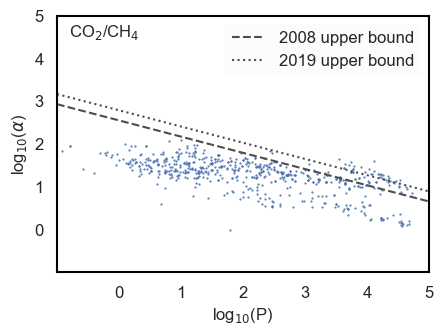

In [4]:
draw_properties(train_data, 'CO2', 'CH4')

In [5]:
from xenonpy.descriptor import fingerprint

fp_class = fingerprint.ECFP(radius=2, input_type='smiles')
fp = fp_class.transform(train_data['SMILES'], return_type='df')

In [6]:
with open('../models/model_CO2.pkl', 'rb') as f:
    model_CO2 = pickle.load(f)
with open('../models/model_CH4.pkl', 'rb') as f:
    model_CH4 = pickle.load(f)

In [11]:
train_data

,SMILES,He,H2,N2,O2,CO2,CH4,alpha_CO2_CH4,k_CO2_CH4
0,*c1ccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=O...,1.908360,1.890980,0.176091,0.907411,1.591065,-0.148742,1.739806,2.343456
1,*c1ccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=O...,2.038954,2.029384,0.409933,1.103804,1.792392,0.117271,1.675120,2.355154
2,*c1ccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=O...,2.193566,2.195900,0.651278,1.328380,2.060698,0.399674,1.661024,2.442853
3,*c1cccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=...,1.667569,1.531479,-0.468521,0.342423,0.924279,-0.886057,1.810336,2.161008
4,*c1cccc(N2C(=O)c3ccc(C(c4ccc5c(c4)C(=O)N(*)C5=...,1.757188,1.673021,-0.267606,0.544068,1.123852,-0.677781,1.801632,2.228022
...,...,...,...,...,...,...,...,...,...
605,*CC(*)OC(=O)c1ccc(C)cc1,1.164353,1.098777,-0.469800,0.235528,0.828015,-0.379864,1.207879,1.522028
606,*CC(*)OC(=O)c1ccccc1C,0.848805,0.911010,-1.066007,-0.327902,0.348305,-0.939302,1.287607,1.419754
607,*CC(*)OC(=O)c1cccc(C)c1,0.915400,0.885753,-1.057992,-0.304518,0.328380,-0.928118,1.256498,1.381085
608,*CC(*)OC(=O)c1ccccc1,1.029384,0.700278,-0.713510,-0.437361,0.800717,-1.280573,2.081290,2.385082


In [7]:
%%time
from xenonpy.inverse.iqspr import GaussianLogLikelihood
prop = ['CO2','CH4','k_CO2_CH4']
target_range = {'CO2':(-6,6), 'CH4':(-6,6), 'k_CO2_CH4': (2.7898, np.inf)}

custom_model = {'CO2':model_CO2, 'CH4':model_CH4}
model = GaussianProcessRegressor(kernel=kernels.RBF() + kernels.WhiteKernel(), n_restarts_optimizer=0, normalize_y=True, n_targets=1)
model_k = model.fit(fp, train_data['k_CO2_CH4'])
custom_model['k_CO2_CH4'] = model_k

prd_mdls = GaussianLogLikelihood(descriptor=fp_class, targets = target_range, **custom_model)
prd_mdls.update_targets(reset=True,**target_range)

CPU times: user 12.2 s, sys: 9.91 s, total: 22.1 s
Wall time: 9.01 s


In [9]:
output2 = prd_mdls.predict(train_data['SMILES'])
output2

/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


,CO2: mean,CO2: std,CH4: mean,CH4: std,k_CO2_CH4: mean,k_CO2_CH4: std
0,1.609918,0.452534,-0.080567,0.548082,2.278842,0.168210
1,1.609918,0.452534,-0.080567,0.548082,2.278842,0.168210
2,1.609918,0.452534,-0.080567,0.548082,2.278842,0.168210
3,1.196311,0.466821,-0.560083,0.565398,2.199429,0.172252
4,1.196311,0.466821,-0.560083,0.565398,2.199429,0.172252
...,...,...,...,...,...,...
605,0.784945,0.534909,-0.416881,0.647077,1.670424,0.190569
606,0.595193,0.551460,-0.673215,0.667174,1.638414,0.198424
607,0.514791,0.546202,-0.744310,0.660812,1.614210,0.195680
608,0.715425,0.585548,-0.511947,0.706183,1.856394,0.188461


In [10]:
%%time
tmp_ll = prd_mdls(train_data['SMILES'], **target_range)
tmp_ll

/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


CPU times: user 4.71 s, sys: 2.35 s, total: 7.06 s
Wall time: 4.11 s


,CO2,CH4,k_CO2_CH4
0,-1.491263e-22,-6.687386e-29,-6.731869
1,-1.491263e-22,-6.687386e-29,-6.731869
2,-1.491263e-22,-6.687386e-29,-6.731869
3,-3.899801e-25,-1.998739e-31,-8.096053
4,-3.899801e-25,-1.998739e-31,-8.096053
...,...,...,...
605,-9.276569e-23,-1.760690e-23,-19.967744
606,-5.578803e-23,-6.661338e-16,-19.540400
607,-4.958833e-24,-8.881784e-16,-20.784234
608,-8.983975e-20,-3.885795e-15,-14.821165


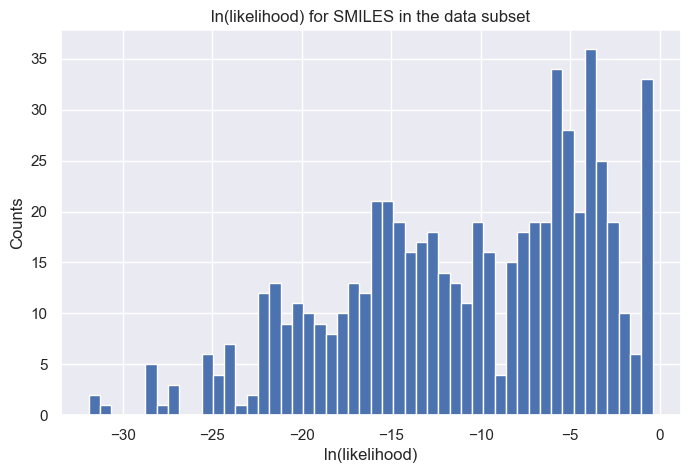

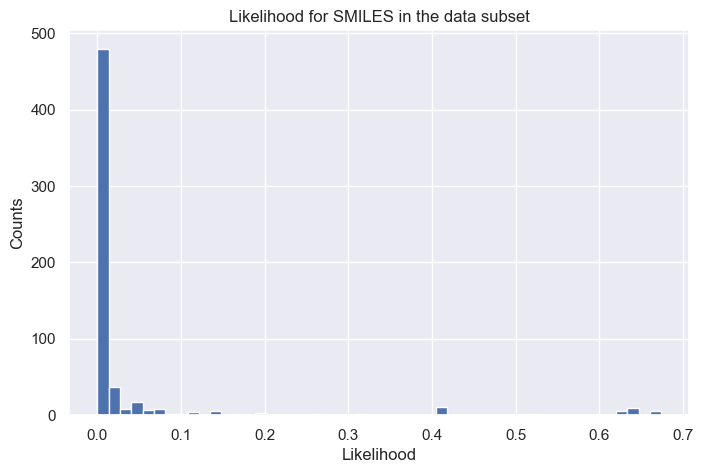

In [11]:
tmp = tmp_ll.sum(axis = 1, skipna = True)

_ = plt.figure(figsize=(8,5))
_ = plt.hist(tmp, bins=50)
_ = plt.title('ln(likelihood) for SMILES in the data subset')
_ = plt.xlabel('ln(likelihood)')
_ = plt.ylabel('Counts')
_ = plt.show()

# plot histogram of likelihood values
_ = plt.figure(figsize=(8,5))
_ = plt.hist(np.exp(tmp), bins=50)
_ = plt.title('Likelihood for SMILES in the data subset')
_ = plt.xlabel('Likelihood')
_ = plt.ylabel('Counts')
_ = plt.show()

In [12]:
%%time

from xenonpy.inverse.iqspr import NGram

n_gram = NGram()

n_gram.fit(train_data['SMILES'],train_order=5)

/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/xenonpy/inverse/iqspr/modifier.py:166: RuntimeWarning: max <sample_order>: 10 is greater than max <train_order>: 5,max <sample_order> will be reduced to max <train_order>
  warnings.warn(
100%|██████████| 610/610 [00:37<00:00, 16.29it/s]


CPU times: user 36.5 s, sys: 1.08 s, total: 37.6 s
Wall time: 37.4 s


NGram(ngram_table=[[[             c    &    !    O    C    (  =O   N   /  =C  [Si]  *  n  -c  F  \
['*']      260    0   10  179   48    0   0  41  76   5     0  0  0   0  0   
['c']        0  553    0    0    0    0   0   0   0   0     0  0  0   0  0   
[0]          0   12  438   58   61    8   4   0   0   0     2  0  0   2  0   
['O']      184    0   46    0   27    0   0   0   0   0     0  9  0   0  0   
['C']        1    8  100    5  112  162   0  13   0   4     1  1  0   0  0   
[')']       79    0    0   24   73   49   1   2   0  19     9  0  1   0  5   
['=O']       0    0    5    0    0    0   0   0   0   0     0  0  0   0  0   
['N']       28   15    0    0    2    0   0   0   0   0     0  0  0   0  0   
['/']        0    0    0    0   79    0   0   0   0   0     0  0  0   0  0   
['=C']       0    0    0    0    5   20   0   0   3   0     0  0  0   0  0   
['[Si]']     0    0    0    0    0   12   0   0   0   0     0  0  0   0  0   
['n']        0    1    0    0    0    0   0   0   0   0     0  0  0   0  0   
['-c']       0    2    0    0    0    0   0   0   0   0     0  0  0   0  0   
['F']        0    0...
['C', '(', 'c', '&', 'c']  5  0  0
['(', 'c', '&', 'c', 'c']  5  0  0
['c', '&', 'c', 'c', 'c']  0  5  0
['*', ')', 'o', 'c', 0]    5  0  0
[')', 'o', 'c', 0, 'c']    0  0  5,
                                                n  c  (  *  )  o  0
['&', 'c', 'c', 'c', '&']  5  0  0  0  0  0  0
['c', 'c', 'c', '&', 'n']  0  5  0  0  0  0  0
['c', 'c', '&', 'n', 'c']  0  0  5  0  0  0  0
['c', '&', 'n', 'c', '(']  0  0  0  5  0  0  0
['&', 'n', 'c', '(', '*']  0  0  0  0  5  0  0
['n', 'c', '(', '*', ')']  0  0  0  0  0  5  0
['c', '(', '*', ')', 'o']  0  5  0  0  0  0  0
['(', '*', ')', 'o', 'c']  0  0  0  0  0  0  5]]],
      sample_order=(1, 5))

In [13]:
np.random.seed(202309) # fix the random seed
cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for i, smi in enumerate(train_data['SMILES'])]
init_samples = np.random.choice(cans,len(cans))
init_samples

array(['*CC(*)c1ccc(C(C)(C)C)cc1',
       '*Oc1ccc(C(C)(C)c2ccc(Oc3c(F)c(F)c(COC(C)(C)c4cccc(C(C)(C)OCc5c(F)c(F)c(*)c(F)c5F)c4)c(F)c3F)cc2)cc1',
       '*Oc1cc2c(cc1O*)C1(CC2(C)C)CC(C)(C)c2cc3c(cc21)Oc1c(C#N)c(*)c(*)c(C#N)c1O3',
       '*Oc1c(C)cc(C(C)(C)c2ccc(C(C)(C)c3cc(C)c(Oc4ccc(S(=O)(=O)c5ccc(*)cc5)cc4)c(C)c3)cc2)cc1C',
       '*N=P(N=P(*)(Cl)Oc1cc(C(C)(C)C)cc(C(C)(C)C)c1)(Oc1cc(C(C)(C)C)cc(C(C)(C)C)c1)Oc1cc(C(C)(C)C)cc(C(C)(C)C)c1',
       '*Oc1cc2c(cc1O*)C1(CC2(C)C)CC(C)(C)c2cc3c(cc21)Oc1c(C#N)c(*)c(*)c(C#N)c1O3',
       '*Oc1cc2c(cc1O*)[C@]1(C)c3cc4c(cc3C2(C)c2cc3ccccc3cc21)Oc1c(C#N)c(*)c(*)c(C#N)c1O4',
       '*c1ccc(Oc2ccc(N3C(=O)c4ccc(C(c5ccc6c(c5)C(=O)N(*)C6=O)(C(F)(F)F)C(F)(F)F)cc4C3=O)cc2)cc1',
       '*Oc1cc2c(cc1O*)C1(CC2(C)C)CC(C)(C)c2cc3c(cc21)Oc1cc2nc4cc5c(cc4nc2cc1O3)C(C)(C)CC51CC(C)(C)c2cc3nc4cc(*)c(*)cc4nc3cc21',
       '*Oc1ccc(C(=C(Cl)Cl)c2ccc(OC(*)=O)cc2)cc1',
       '*Oc1ccc(-c2ccc(Oc3c(F)c(F)c(COC(C)(C)c4cccc(C(C)(C)OCc5c(F)c(F)c(*)c(F)c5F)c4)c(F)c3F)cc2)cc1'

In [14]:
pre_beta = np.linspace(-5,5,80)
sig = 1 / (1 + np.exp(-pre_beta))
beta = np.hstack([sig, np.linspace(0.9934,1,10), np.linspace(1,1,10)])
print('Number of steps: %i' % len(beta))
print(beta)

Number of steps: 100
[0.00669285 0.00758915 0.00860444 0.00975422 0.01105593 0.01252916
 0.01419587 0.0160807  0.01821116 0.02061796 0.02333528 0.02640107
 0.02985733 0.03375038 0.03813109 0.04305507 0.04858278 0.05477955
 0.06171545 0.069465   0.07810664 0.08772199 0.0983947  0.11020904
 0.12324803 0.13759113 0.15331154 0.17047304 0.18912646 0.20930597
 0.23102516 0.25427333 0.27901212 0.30517284 0.33265471 0.36132445
 0.39101732 0.42153976 0.45267374 0.48418249 0.51581751 0.54732626
 0.57846024 0.60898268 0.63867555 0.66734529 0.69482716 0.72098788
 0.74572667 0.76897484 0.79069403 0.81087354 0.82952696 0.84668846
 0.86240887 0.87675197 0.88979096 0.9016053  0.91227801 0.92189336
 0.930535   0.93828455 0.94522045 0.95141722 0.95694493 0.96186891
 0.96624962 0.97014267 0.97359893 0.97666472 0.97938204 0.98178884
 0.9839193  0.98580413 0.98747084 0.98894407 0.99024578 0.99139556
 0.99241085 0.99330715 0.9934     0.99413333 0.99486667 0.9956
 0.99633333 0.99706667 0.9978     0.99853333 

In [15]:
%%time

from xenonpy.inverse.iqspr import IQSPR

iqspr_reorder = IQSPR(estimator=prd_mdls, modifier=n_gram)

np.random.seed(202309)

# main loop of iQSPR

iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for s, ll, p, freq in iqspr_reorder(init_samples, beta, yield_lpf=True):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
    
# record all outputs

iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}
# save results
with open('iQSPR_results_reorder1.obj', 'wb') as f:
    pk.dump(iqspr_results_reorder, f)

/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


Unexpected exception formatting exception. Falling back to standard exception


/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/xenonpy/inverse/iqspr/modifier.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_pd_row.at['substr'] = new_pd_row['substr'] + [next_char]
/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/xenonpy/inverse/iqspr/modifier.py:492: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_pd_row.at['esmi'] = next_char
/home/naoren/anaconda3/envs/cpoly/lib/python3.9/site-packages/xenonpy/inverse/iqspr/modifier.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https: